In [15]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline 

In [16]:
def f(x):
    return 3*x**2 - 4*x + 5

In [17]:
f(3.0)

20.0

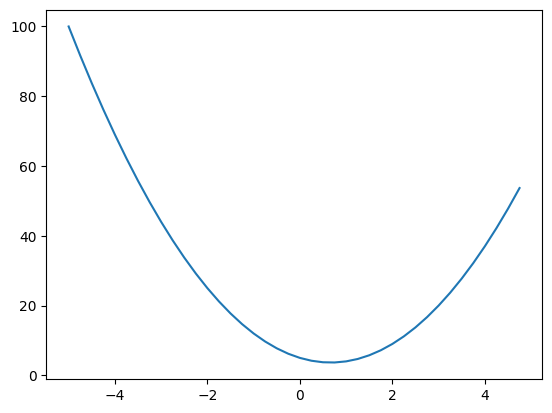

In [18]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [19]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [20]:
# more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [21]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [211]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label= label
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + -(other)
    
    def __radd__(self, other):
        return self + other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def tanh(self):
        numerator = math.exp(2 * self.data) - 1
        denominator = math.exp(2 * self.data) + 1
        t = numerator / denominator
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

# a = Value(2.0, label='a')
# b = Value(-3.0, label='b')
# c = Value(10.0, label='c')
# e = a*b; e.label = 'e'
# d = e + c ; d.label = 'd'
# f = Value(-2.0, label='f')
# L = d * f ; L.label = 'L'
# L

In [212]:
a = Value(2.0, label="a")
b = Value(4.0, label="b")
a - b

Value(data=-2.0)

In [23]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

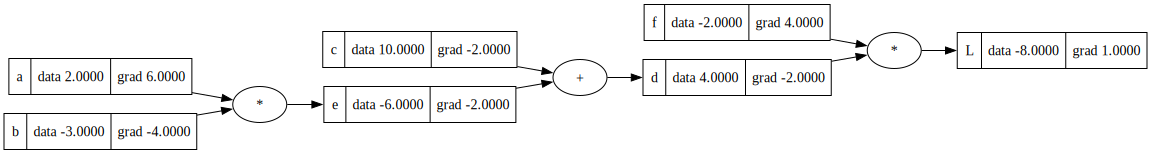

In [24]:
# L = d * f
# dL / dd = f

# (f(x+h) - f(x))/h
# ((d+h)*f - d*f)/h
# (d*f + h*f - d*f)/h
# h*f/h
# f

L.grad = 1.0
f.grad = 4.0
d.grad = -2.0

# dL / dc = ?
# dd / dc
# d = e + c
# f(x+h) - f(x) / h
# (e+c+h) - e - c / h
# h/h = 1.0 = dd / dc

# by symmetry, dd / de = 1.0

# dd / dc = 1.0
# dd / de = 1.0
# Use chain rule to get dL / dc
# dL / dc = (dL/dd) * (dd/dc) = -2.0 * 1.0 = -2.0
c.grad = -2.0
e.grad = -2.0

# dL / db = ?
# Use chain rule !
# dL / db = dL / dd * dd / de * de / db
# dL / db = -2.0 * 1.0 * db / de
# db / de = ?
# e = b * a
# e = a
# f(x+h) - f(x) / h
# (b+h)*a - b*a / h
# ba + ha - ba / h
# ha / h
# db / de = a = 2.0
# dL / db = -2.0 * 1.0 * 2.0
# dL / db = -4.0
b.grad = -4.0

# dL / da = ?
# Use chain rule and previous derived values
# dL / db = dL / dd * dd / de * de / da
# by symmetry, da / de = b = -3.0
# dL / db = -2.0 * 1.0 * -3.0 = 6.0
a.grad = 6.0





draw_dot(L)


In [25]:
# one optimization step
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * d.grad
e = b * a
d = e + c
L = d * f
L

Value(data=-7.509552)

In [26]:
def lol():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c ; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f ; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c ; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f ; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

lol()

-3.9999999999995595


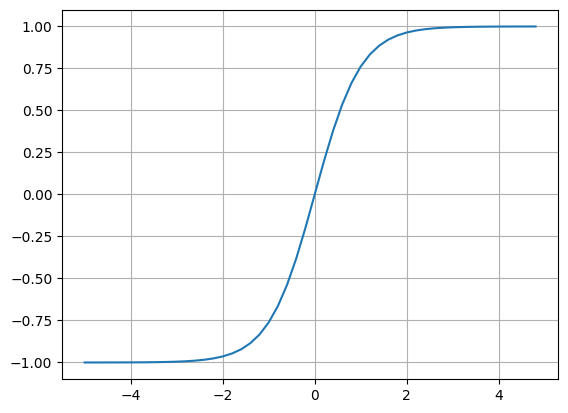

In [27]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

Python(61751) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


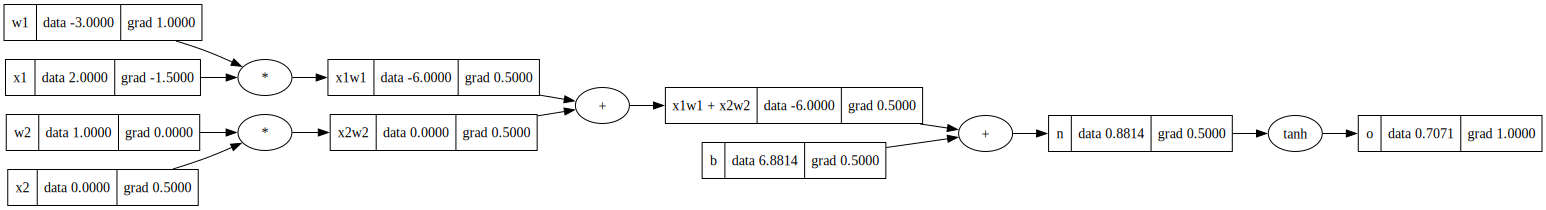

In [214]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# Weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
x1w1 = x1 * w1 ; x1w1.label = "x1w1"
x2w2 = x2 * w2 ; x2w2.label = "x2w2"
# bias
b = Value(6.8813735870195432, label="b")
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b ; n.label = "n"
o = n.tanh() ; o.label = "o"
o.backward()
draw_dot(o)

x1.grad: 0.0, x2.grad: 0.0, w1.grad: 0.0, w2.grad: 0.0, x1w1.grad: 0.0, x2w2: 0.0, b.grad: 0.0, x1w1x2w2: 0.0, e.grad: 0.0, o.grad 0.0


Python(61737) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


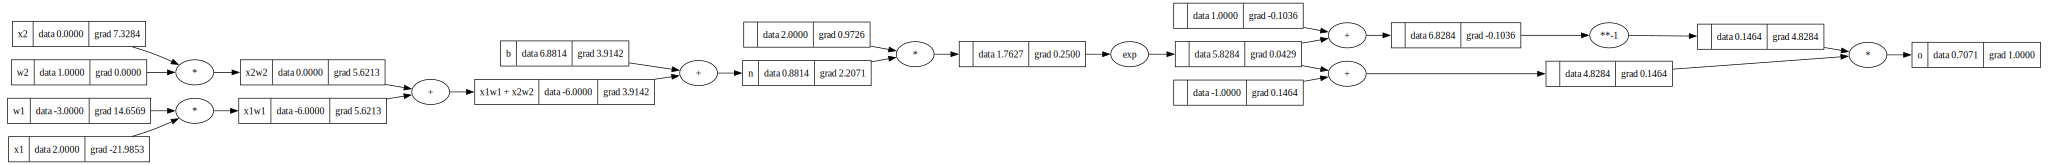

In [213]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# Weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
x1w1 = x1 * w1 ; x1w1.label = "x1w1"
x2w2 = x2 * w2 ; x2w2.label = "x2w2"
# bias
b = Value(6.8813735870195432, label="b")
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b ; n.label = "n"
#o = ((n*2).exp() - 1) / ((n*2).exp() + 1)
e = (2*n).exp() 
o = (e - 1) / (e + 1)
o.label = "o"
print(f"x1.grad: {x1.grad}, x2.grad: {x2.grad}, w1.grad: {w1.grad}, w2.grad: {w2.grad}, x1w1.grad: {x1w1.grad}, x2w2: {x2w2.grad}, b.grad: {b.grad}, x1w1x2w2: {x1w1x2w2.grad}, e.grad: {e.grad}, o.grad {o.grad}")
o.backward()
draw_dot(o)

In [70]:
# Manually Set the grads (deivatives)
# In general, along the nodes, the + operator "distributes" the child node grad amongst the parents for the local derivatirve
# the * operator swaps the operands data values for the other's grad value. e.g. 
b.grad = 0.5
n.grad = 0.5 # do / dn = 1 - tanh(n)**2 = 1 - o**2
o.grad = 1.0
x1w1.grad = 0.5
x2w2.grad = 0.5
x1w1x2w2.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
b.grad = 0.5
n.grad = 0.5 # do / dn = 1 - tanh(n)**2 = 1 - o**2
o.grad = 1.0


In [94]:
# Set the grads with backwards
o.grad = 1.0
o._backward()
n._backward()
b._backward() # but it's a leaf node, so the function return None
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [40]:
1 - o.data**2

0.4999999999999999

In [123]:
# o = tanh(n)
# do / dn
# do / dn = 1 - tanh(n)**2
# do / dn = 1 - o**2

Python(61051) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


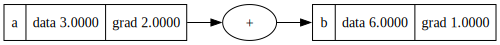

In [131]:
# We need to accumlate derivatives, or else below will not work
# (fix: make += in the original value nodes)
a = Value(3.0, label = "a")
b = a + a ; b.label = "b"
b.backward()
draw_dot(b)

Python(68079) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


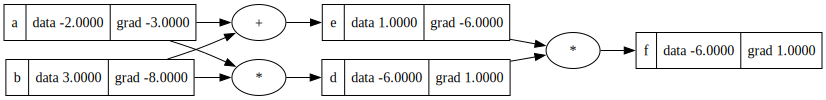

In [215]:
a = Value(-2.0, label="a")
b = Value(3.0, label = "b")
d = a * b ; d.label = "d"
e = a + b ; e.label = "e"
f = d * e ; f.label = "f"

f.backward()
draw_dot(f)

In [217]:
import torch

In [242]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([-1.0]).double() ; w2.requires_grad = True

x1w1 = x1 * w1 
x2w2 = x2 * w2
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1w1 + x2w2 + b
o = torch.Tensor.tanh(n)
o.backward()


print(f"x1.grad = {x1.grad}")
print(f"x2.grad = {x2.grad}")
print(f"w1.grad = {w1.grad}")
print(f"w2.grad = {w2.grad}")
print(f"x1w1.grad = {x1w1.grad}")
print(f"x2w2.grad = {x2w2.grad}")
print(f"o = {o}")

f = [1,2,3] + [1]
f

x1.grad = tensor([-1.5000], dtype=torch.float64)
x2.grad = tensor([-0.5000], dtype=torch.float64)
w1.grad = tensor([1.0000], dtype=torch.float64)
w2.grad = tensor([0.], dtype=torch.float64)
x1w1.grad = None
x2w2.grad = None
o = tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)


/var/folders/60/1xnrhcbj19zbv15wmz3jzrth0000gn/T/ipykernel_49266/1695841239.py:18: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  print(f"x1w1.grad = {x1w1.grad}")
/var/folders/60/1xnrhcbj19zbv15wmz3jzrth0000gn/T/ipykernel_49266/1695841239.py:19: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on th

[1, 2, 3, 1]

Python(71442) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


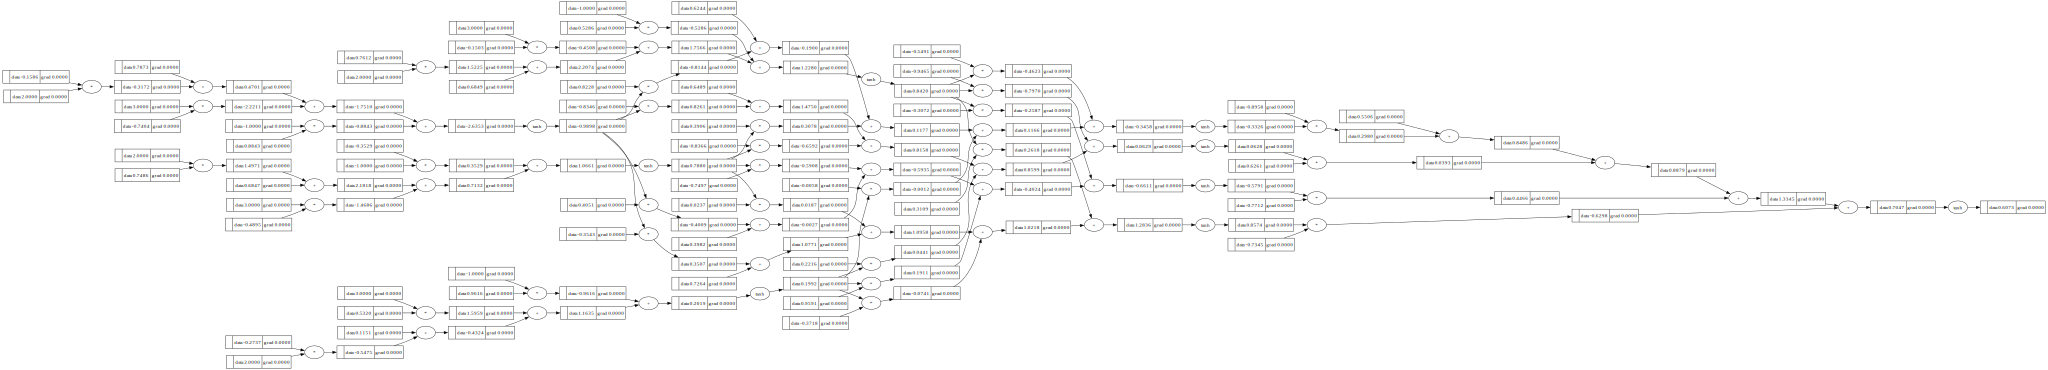

In [267]:
import random

class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, input):
        outs = [n(input) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


# x = [2.0, 3.0]
# n = Layer(2, 3)
# n(x)

x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)

draw_dot(n(x))

In [274]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1,0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.6073218987654383),
 Value(data=-0.6659740369303765),
 Value(data=-0.8741901502004622),
 Value(data=0.43534601804456446)]

In [280]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=0.15419609118918068),
 Value(data=0.11157334400458949),
 Value(data=0.01582811830658226),
 Value(data=0.3188341193381293)]

In [279]:
(-0.665974-(-1.0))**2


0.11157336867600003